In [1]:
import numpy as np
from utils import es
from utils import itd
from utils import prob

import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline

from python_speech_features import logfbank

from scipy.io import wavfile
import re
from scipy import stats
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import gammamix
import matplotlib.ticker as ticker

from tqdm import tqdm

/home/enea/anaconda2/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/home/enea/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/enea/anaconda2/lib/python2.7/site-packages/scipy/linalg/__init__.py:202: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/enea/anaconda2/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/home/enea/anaconda2/lib/python2.7/site-packages/scipy/sparse/lil.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary 

In [2]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{xcolor}', r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Computer Modern Sans serif' # Choose a nice font here
plt.rcParams['font.size'] = 18

In [4]:
basedir = '/Data/DATASETS/CAESAR_TIDIGITS/'
# basedir = '/home/enea/Downloads/ex_manual_itds/priors/'
filename = basedir + 'priors/' + 'prior_long_hv_mf_7_90'
imgs_folder = './imgs/'
num_bins = 80
max_itd = 800e-6
num_channels = 64
a, b = 10000, -100
# load file
timestamps, addresses = es.loadaerdat(filename + '.aedat')
timestamps = timestamps[a:b]
addresses = addresses[a:b]

timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)
w = channel_id == 24
_itds = itd.get_itds(timestamps[w], ear_id[w], neuron_id[w], save_to_file=None,
                                 verbose=False, max_itd=max_itd)
#remove trigger

In [ ]:
a = plt.hist(_itds, 100)

In [ ]:
a, b = 10000, -100
# plt.plot(timestamps[ear_id==0][a:b], channel_id[ear_id==0][a:b] % 64, '*')
# plt.plot(timestamps[ear_id==1][a:b], channel_id[ear_id==1][a:b] % 64, '*')

plt.plot(timestamps[ear_id==0][a:b], '*')
plt.plot(timestamps[ear_id==1][a:b], '*')

In [5]:
dict_c = {}

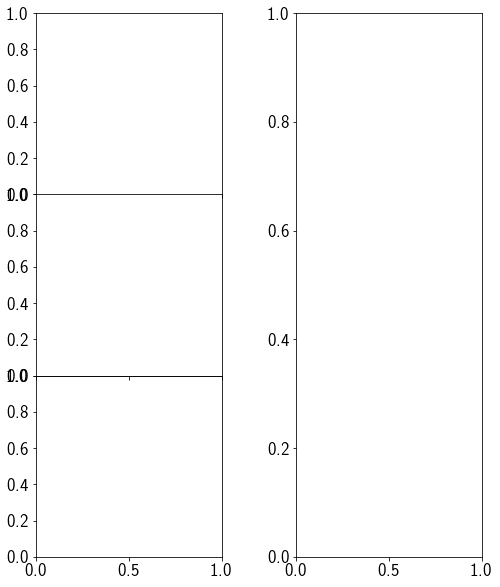

In [57]:
from scipy.stats import norm
fig = plt.figure(figsize=(8,10))

ax1 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)

ax4 = plt.subplot2grid((3, 2), (2, 0))
ax2 = plt.subplot2grid((3, 2), (0, 0), sharex=ax4)
ax3 = plt.subplot2grid((3, 2), (1, 0), sharex=ax4)


plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0.0, wspace=0.4)
filename = basedir + 'priors/' + 'prior_long_hv_mf_7_{}'.format(90)

timestamps, addresses = es.loadaerdat(filename + '.aedat')
timestamps = timestamps[a:b]
addresses = addresses[a:b]
timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

all_x = []
all_itds = []
all_p = []

for i in range(0,64):
    w = channel_id == i
    try:
        _itds, _ = itd.get_itds(timestamps[w], ear_id[w], neuron_id[w], save_to_file=None,
                                 verbose=False, max_itd=max_itd, return_itd_indices=True)
        
        mu, std = norm.fit(_itds)
        if not np.isnan(mu):
#             print "CH: {} => #EVS = {}".format(i, len(_itds))
            dict_c[i] = {'mu': mu, 'std':std}
#             print "\t {:.4} - {:.4}".format(mu, std)
            x = np.linspace(-max_itd, max_itd, 160)
            p = norm.pdf(x, mu, std)
            if i in [19, 24, 26]:
                
#                 ax1.plot(x, p, '--', label=i, linewidth=4)
#                 ax1.set_xticklabels([-1, -.8, .0, .8])
#                 ax1.set_xticklabels([-1, -.8, -.6, -.4, -.2, .0, .2, .4, .6, .8])
                if i == 19:
                    all_x.append(x)
                    all_itds.append(_itds)
                    all_p.append(p)
#                     ax2.hist(_itds, 40, normed=True, label='empirical', alpha = 0.5, color=plt.cm.tab10(0))
#                     ax2.plot(x, p, '--', label='fit', linewidth=4, c = plt.cm.tab10(0))
#                     ax2.set_xticklabels([-1, -.8, -.6, -.4, -.2, .0, .2, .4, .6, .8])
                if i == 24:
                    all_x.append(x)
                    all_itds.append(_itds)
                    all_p.append(p)
#                     ax3.hist(_itds, 40, normed=True, label='empirical', alpha = 0.5, color=plt.cm.tab10(1))
#                     ax3.plot(x, p, '--', label='fit', linewidth=4, c = plt.cm.tab10(1))
#                     ax3.set_xticklabels([-1, -.8, -.6, -.4, -.2, .0, .2, .4, .6, .8])
                if i == 26:
                    all_x.append(x)
                    all_itds.append(_itds)
                    all_p.append(p)
#                     ax4.hist(_itds, 40, normed=True, label='empirical', alpha = 0.5, color=plt.cm.tab10(2))
#                     ax4.plot(x, p, '--', label='fit', linewidth=4, c = plt.cm.tab10(2))
#                     ax4.set_xticklabels([-1, -.8, -.6, -.4, -.2, .0, .2, .4, .6, .8])
#             if not np.isnan(mu):
#                 print "CH: {:4} || MU: {:4} || SIGMA: {:4}".format(i, mu, std)
        else:
            dict_c[i] = {'mu': 0, 'std':0}
    except:
        pass

# scale_x = 1e-6
# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))

# title = ['Some delays', 'Channel 12', 'Channel 24', 'Channels 26']
# for ax, t in zip([ax1, ax2, ax3, ax4], title):
#     ax.legend()
#     ax.grid()
#     ax.set_title(t)
#     ax.set_xlabel('ITDs (us)')
#     ax.set_ylabel('Spike Count')
#     ax.xaxis.set_major_formatter(ticks_x)


# plt.tight_layout()
# plt.savefig(imgs_folder + 'example_correction_v2.pdf', transparent=True)

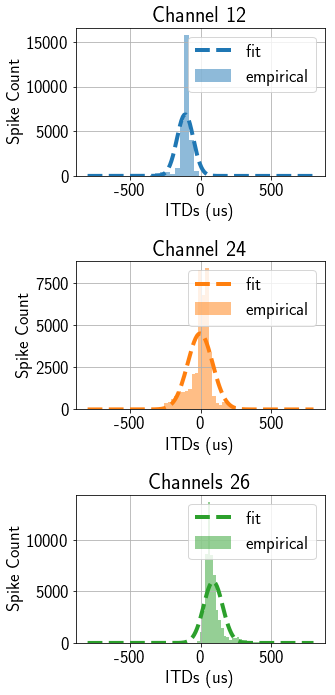

In [72]:
fig = plt.figure(figsize=(5,10))

ax2 = plt.subplot2grid((3, 1), (0, 0))
ax3 = plt.subplot2grid((3, 1), (1, 0))
ax4 = plt.subplot2grid((3, 1), (2, 0))

scale_x = 1e-6
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))

title = ['Channel 12', 'Channel 24', 'Channels 26']
for ax, t, i in zip([ax2, ax3, ax4], title, range(3)):
    ax.hist(all_itds[i], 40, normed=True, label='empirical', alpha = 0.5, color=plt.cm.tab10(i))
    ax.plot(all_x[i], all_p[i], '--', label='fit', linewidth=4, c = plt.cm.tab10(i))
    ax.set_xticklabels([-1, -.8, -.6, -.4, -.2, .0, .2, .4, .6, .8])
    ax.legend()
    ax.grid()
    ax.set_title(t)
    ax.set_xlabel('ITDs (us)')
#     plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_ylabel('Spike Count')
    ax.xaxis.set_major_formatter(ticks_x)

# ax4.set_title(t)
# ax4.set_xlabel('ITDs (us)')
plt.subplots_adjust(hspace=0, wspace=0)
plt.tight_layout()
plt.savefig(imgs_folder + 'example_correction_v2.pdf', transparent=True)

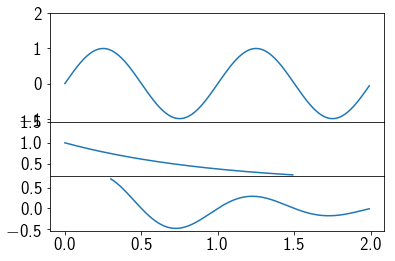

In [30]:
t = np.arange(0.0, 2.0, 0.01)

s1 = np.sin(2*np.pi*t)
s2 = np.exp(-t)
s3 = s1*s2

fig = plt.figure()
ax1 = plt.subplot2grid((4,3), (0,0), colspan=3, rowspan=2)
ax2 = plt.subplot2grid((4,3), (2,0), colspan=3, sharex=ax1)
ax3 = plt.subplot2grid((4,3), (3,0), colspan=3, sharex=ax1)

ax1.plot(t,s1)
ax2.plot(t[:150],s2[:150])
ax3.plot(t[30:],s3[30:])

fig.subplots_adjust(hspace=0)   
for ax in [ax1, ax2]:
    plt.setp(ax.get_xticklabels(), visible=False)
    # The y-ticks will overlap with "hspace=0", so we'll hide the bottom tick
    ax.set_yticks(ax.get_yticks()[1:])  

plt.show()


In [ ]:
timestamps, addresses = es.loadaerdat(filename + '.aedat')
timestamps = timestamps[10000:]
addresses = addresses[10000:]
timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)
plt.plot(timestamps, channel_id, 'o')

In [ ]:
base = '/home/enea/Downloads/'
filename = base + 'NT8202009JA409'
    
timestamps, addresses = es.loadaerdat(filename + '.aedat')
timestamps = timestamps[10000:]
addresses = addresses[10000:]
timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

fig = plt.figure(figsize=(4,4))
for i in [24]:
    ax = fig.add_subplot(1,1,1)
    
    w = channel_id == i
    try:
        _itds, _ = itd.get_itds(timestamps[w], ear_id[w], neuron_id[w], save_to_file=None,
                             verbose=False, max_itd=max_itd)
        ax.plot(prob.get_priors(np.array([_itds]))[0], label=i)
    except:
        pass
plt.legend()

In [9]:
relevant_channels = np.arange(0,64)
# relevant_channels = np.array([19,24,26])
r_ch = np.array([19])
itd_streams = []
itd_streams_only_mu = []
itd_streams_no_corr = []
itd_streams_no_corr_lim = []
for i in tqdm(range(0, 190, 30)):
# for i in tqdm([0, 90, 180]):

    filename = basedir + 'priors/prior_long_hv_mf_7_{}'.format(i)

    timestamps, addresses = es.loadaerdat(filename + '.aedat')
    timestamps = timestamps[100000:]
    addresses = addresses[100000:]
    timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

    _ii = []
    _ii_only_mu = []
    _ii_no_corr = []
    _ii_no_corr_lim = []
    for kk in relevant_channels:
        indices_channels = np.isin(channel_id, np.array([kk]))
        if kk in dict_c:
            try:
                _itds, _ = itd.get_itds(timestamps[indices_channels], ear_id[indices_channels], neuron_id[indices_channels], save_to_file=None,
                                     verbose=False, max_itd=max_itd, return_itd_indices=True)
                _mu = dict_c[kk]['mu'] 
                _corr = ((_itds - _mu) / dict_c[kk]['std']) * (dict_c[24]['std'] / 10) 
                _ii.extend(_corr)
                _ii_only_mu.extend(_itds - _mu)
                _ii_no_corr.extend(_itds)
                if kk in r_ch:
                    _ii_no_corr_lim.extend(_itds)
            except Exception as e:
                print e
    itd_streams.append(_ii)
    itd_streams_only_mu.append(_ii_only_mu)
    itd_streams_no_corr.append(_ii_no_corr)
    itd_streams_no_corr_lim.append(_ii_no_corr_lim)


  0%|          | 0/7 [00:00<?, ?it/s]
/home/enea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in divide

 14%|█▍        | 1/7 [01:07<06:44, 67.40s/it]/home/enea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in divide

100%|██████████| 7/7 [07:37<00:00, 65.53s/it]


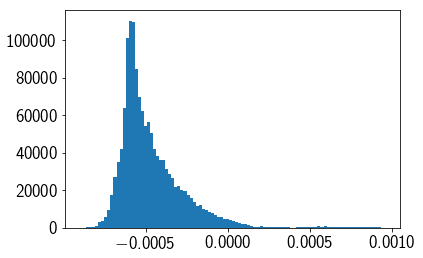

In [10]:
_ = plt.hist(itd_streams_only_mu[0], 100)

In [ ]:
f, ax = plt.subplots(3,3, figsize=(20,10))
for i in range(3):
    ax[i][0].hist(itd_streams[i], normed=True)
    ax[i][0].set_xlim([-max_itd, max_itd])
    ax[i][1].hist(itd_streams_no_corr[i], normed=True)
    ax[i][1].set_xlim([-max_itd, max_itd])
    ax[i][2].hist(itd_streams_only_mu[i], normed=True)
    ax[i][2].set_xlim([-max_itd, max_itd])

plt.tight_layout()

In [ ]:
priors = prob.get_priors(np.array(itd_streams_only_mu))
plt.plot(priors.T)

In [ ]:
_ = plt.hist(itd_streams[0])

In [ ]:
# create some normal random noisy data
IDX = 18
ser = np.array(itd_streams[IDX]) * 1e6

# plot normed histogram
a = plt.hist(ser, 80, normed=True)

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(ser))

priors = prob.get_priors(np.array([itd_streams[IDX]]))

lnspc2 = np.linspace(xmin, xmax, len(priors[0]))

# plt.plot(lnspc2, priors[0])


# guess what :) 
ab,bb,cb,db = stats.beta.fit(ser)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label="Beta")

plt.legend()

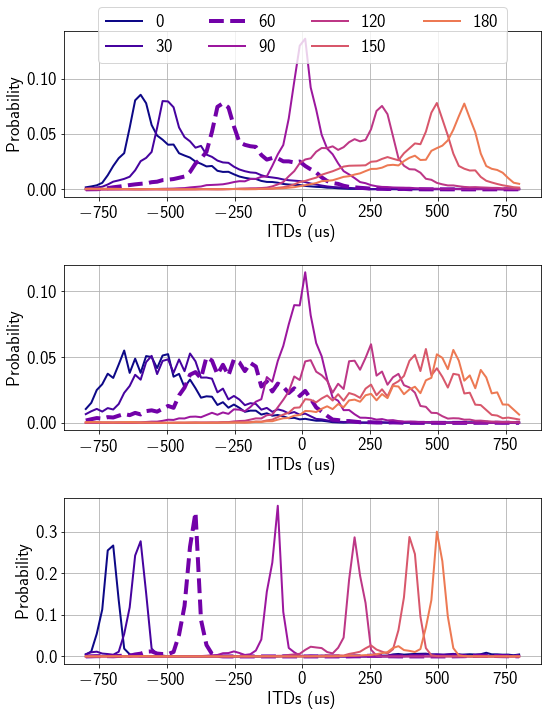

In [24]:
fig = plt.figure(figsize=(8,10))
x = np.linspace(-max_itd * 1e6, max_itd * 1e6, 80)
ax = fig.add_subplot(3,1,1)
priors = prob.get_priors(np.array(itd_streams_only_mu))
color_idx = np.linspace(0, 1, 19)
for i, l, j in zip(color_idx, range(0, 190, 30), priors): 
    c = plt.cm.plasma(i*2)
    ax.plot(x, j, '--' if l == 60 else '-', label=l, linewidth=4 if l == 60 else 2, color=c)
    
ax.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=4, fancybox=True)
ax.set_xlabel('ITDs (us)')
ax.set_ylabel('Probability')
# ax.set_title([i for i in np.arange(0, 64) if i in dict_c])

ax = fig.add_subplot(3,1,2)
priors = prob.get_priors(np.array(itd_streams_no_corr))
for i, l, j in zip(color_idx, range(0, 190, 30), priors): 
    c = plt.cm.plasma(i*2)
    ax.plot(x, j, '--' if l == 60 else '-', label=l,linewidth=4 if l == 60 else 2, color=c)
ax.grid()
# ax.legend()
ax.set_xlabel('ITDs (us)')
ax.set_ylabel('Probability')
# ax.set_title([i for i in np.arange(0, 64) if i in dict_c])

ax = fig.add_subplot(3,1,3)
priors = prob.get_priors(np.array(itd_streams_no_corr_lim))
for i, l, j in zip(color_idx, range(0, 190, 30), priors): 
    c = plt.cm.plasma(i*2)
    ax.plot(x, j, '--' if l == 60 else '-', label=l, linewidth=4 if l == 60 else 2, color=c)
ax.grid()
# ax.legend()
ax.set_xlabel('ITDs (us)')
ax.set_ylabel('Probability')
# ax.set_title("[19]")

plt.tight_layout()
plt.savefig(imgs_folder + 'comparison_priors_v2.pdf', transparent=True)

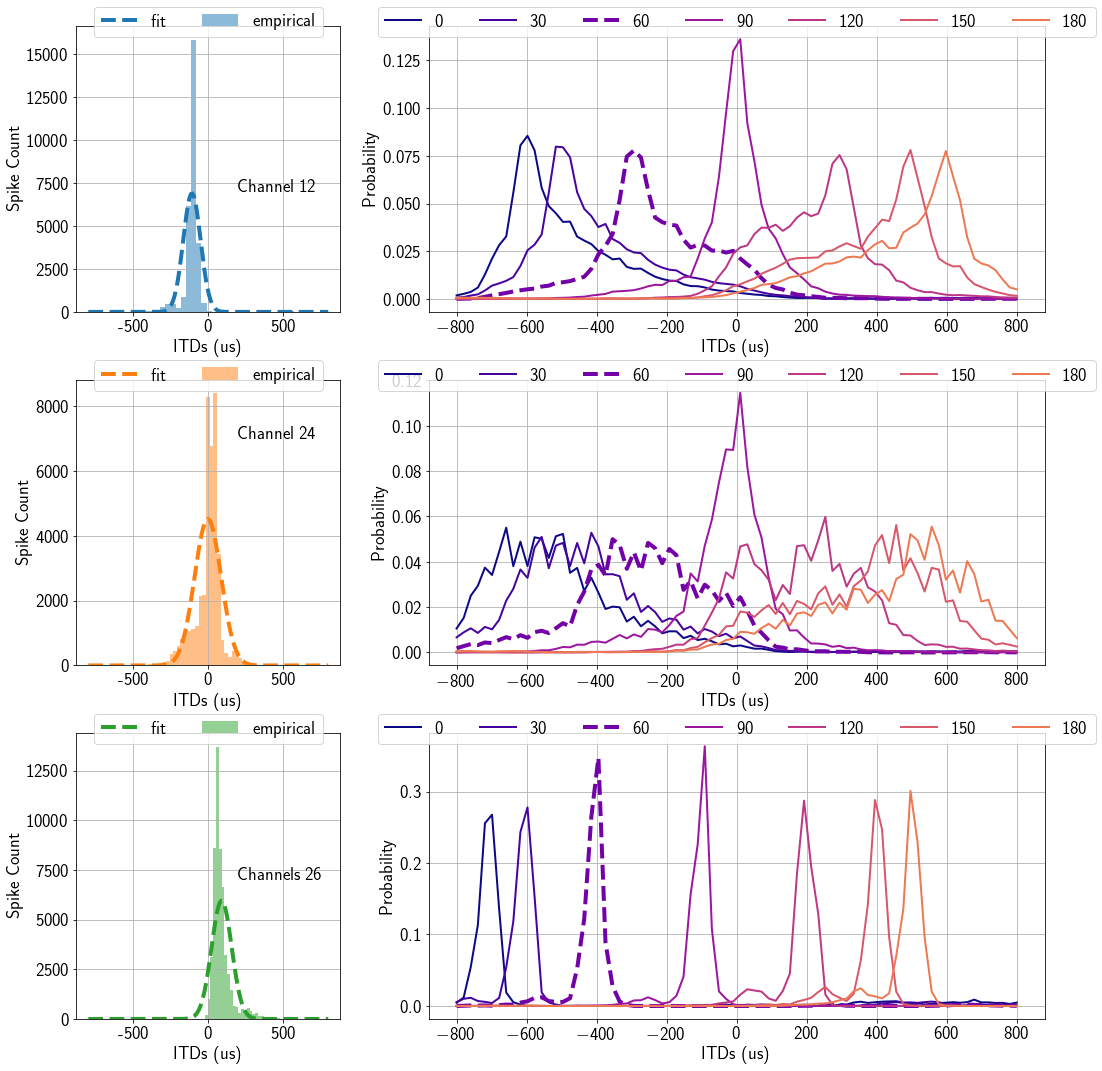

In [89]:
plt.figure(figsize=(15,15))

ax1 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
ax2 = plt.subplot2grid((3, 3), (1, 1), colspan=2)
ax3 = plt.subplot2grid((3, 3), (2, 1), colspan=2)

ax4 = plt.subplot2grid((3, 3), (0, 0))
ax5 = plt.subplot2grid((3, 3), (1, 0))
ax6 = plt.subplot2grid((3, 3), (2, 0))

############## CORRECTION #################
x = np.linspace(-max_itd * 1e6, max_itd * 1e6, 80)

priors = prob.get_priors(np.array(itd_streams_only_mu))
color_idx = np.linspace(0, 1, 19)
for i, l, j in zip(color_idx, range(0, 190, 30), priors): 
    c = plt.cm.plasma(i*2)
    ax1.plot(x, j, '--' if l == 60 else '-', label=l, linewidth=4 if l == 60 else 2, color=c)
    
ax1.grid()
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=10, fancybox=True)
ax1.set_xlabel('ITDs (us)')
ax1.set_ylabel('Probability')
# ax.set_title([i for i in np.arange(0, 64) if i in dict_c])

priors = prob.get_priors(np.array(itd_streams_no_corr))
for i, l, j in zip(color_idx, range(0, 190, 30), priors): 
    c = plt.cm.plasma(i*2)
    ax2.plot(x, j, '--' if l == 60 else '-', label=l,linewidth=4 if l == 60 else 2, color=c)
ax2.grid()
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=10, fancybox=True)
ax2.set_xlabel('ITDs (us)')
ax2.set_ylabel('Probability')
# ax.set_title([i for i in np.arange(0, 64) if i in dict_c])

priors = prob.get_priors(np.array(itd_streams_no_corr_lim))
for i, l, j in zip(color_idx, range(0, 190, 30), priors): 
    c = plt.cm.plasma(i*2)
    ax3.plot(x, j, '--' if l == 60 else '-', label=l, linewidth=4 if l == 60 else 2, color=c)
ax3.grid()
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=10, fancybox=True)
ax3.set_xlabel('ITDs (us)')
ax3.set_ylabel('Probability')
# ax.set_title("[19]")
############### END ################

################# OTHER ##################

scale_x = 1e-6
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))

title = ['Channel 12', 'Channel 24', 'Channels 26']
for ax, t, i in zip([ax4, ax5, ax6], title, range(3)):
    ax.hist(all_itds[i], 40, normed=True, label='empirical', alpha = 0.5, color=plt.cm.tab10(i))
    ax.plot(all_x[i], all_p[i], '--', label='fit', linewidth=4, c = plt.cm.tab10(i))
    ax.set_xticklabels([-1, -.8, -.6, -.4, -.2, .0, .2, .4, .6, .8])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=2, fancybox=True)    
    ax.grid()
#     ax.set_title(t)
    ax.set_xlabel('ITDs (us)')
#     plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_ylabel('Spike Count')
    ax.xaxis.set_major_formatter(ticks_x)
    ax.text(200 * scale_x, 7000, t)

# ax4.set_title(t)
# ax4.set_xlabel('ITDs (us)')

###################### END ###################

# plt.subplots_adjust(hspace=0, wspace=0)
plt.tight_layout()
plt.savefig(imgs_folder + 'correction_v3.pdf', transparent=True)

In [ ]:
print "I can use more spikes with the correction"
print sum([len(i) for i in itd_streams])
print sum([len(i) for i in itd_streams_no_corr])
print sum([len(i) for i in itd_streams_no_corr_lim])
print sum([len(i) for i in itd_streams]) / sum([len(i) for i in itd_streams_no_corr_lim])

In [ ]:
plt.figure(figsize=(12,12))
priors = prob.get_priors(np.array(itd_streams_only_mu))
for l, j in zip(range(0, 190, 10), priors): 
    plt.plot(j, label=l)
plt.legend()
plt.title([i for i in np.arange(0, 65) if i in dict_c])

In [ ]:
np.save('priors_long_hv_mf_7_corrected_all', priors)
import pickle as pkl
pkl.dump(dict_c, open('correction_dict_mf_7.pkl', 'w'))

In [ ]:
np.save('priors_long_hv_corrected_10_30', priors)

In [ ]:
priors = np.load('priors_long_hv_corrected_all.npy')
plt.figure(figsize=(12,12))
for l, j in zip(range(0, 190, 10), priors): 
    plt.plot(j, label=l)
plt.legend()

In [ ]:
def remove_trigger(timestamps, addresses):
    dx = 0.000001
    idx =  np.argmax(np.diff(timestamps)/dx)
    return timestamps[idx + 1:], addresses[idx + 1:]

In [ ]:
priors = np.load('priors_long_hv_mf_7_corrected_all.npy')
dict_c = pkl.load(open('correction_dict_mf_7.pkl', 'r'))
itd_dict = itd.get_itd_dict(max_itd, num_bins)*1e6
_ = plt.plot(priors.T)
print priors.shape

In [ ]:
with open(basedir + 'aedat7/spikes_7/' + 'log_train.txt') as t:
    all_angles = [x for x in t.readlines()]

In [ ]:
all_train = []
gts1 = []
gts2 = []
with open('train_set.txt') as t:
    all_train = [line.split(' ')[4].strip() for line in t.readlines()]
with open('train_set.txt') as t:
    gts1 = [line.split(' ')[0].strip() for line in t.readlines()]
with open('train_set.txt') as t:
    gts2 = [line.split(' ')[1].strip() for line in t.readlines()]

IDX = 37
print all_train[IDX]
print all_angles[IDX]
timestamps, addresses = es.loadaerdat(basedir + 'aedat7/spikes_7/aedat/train/' + all_train[IDX] + '.aedat')
timestamps, addresses = remove_trigger(timestamps, addresses)

timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

# load wav
spk1, spk2, _ = re.compile('[0-9]+').split(all_train[IDX])
_, utt1, utt2 = re.compile('[A-Z]+').split(all_train[IDX])
pos1, pos2 = int(float(all_angles[IDX].split(' ')[1])) , int(float(all_angles[IDX].split(' ')[2]))

pos_dict = {0:0, 30:1, 60:2, 90:3, 120:4, 150:5, 180:6}
pos1 = pos_dict[pos1]
pos2 = pos_dict[pos2]

print pos1
print pos2
# fs, w1 = wavfile.read(basedir + 'wavs/train/' + gts1[IDX].replace('\\', '/') + '.wav')
# fs, w2 = wavfile.read(basedir + 'wavs/train/' + gts2[IDX].replace('\\', '/') + '.wav')

In [ ]:
from collections import OrderedDict
import itertools
idx_dict = {}
_aa = {}
for kk in np.arange(0,64):
    indices_channels = np.isin(channel_id, np.array([kk]))
#     print "CH {} LEN {}".format(kk, len(timestamps[indices_channels]))
#     print timestamps[indices_channels]
#     print ear_id[indices_channels]
#     print neuron_id[indices_channels]
    try:
        if kk in dict_c:

                _itds, _itd_idx = itd.get_itds(timestamps[indices_channels], ear_id[indices_channels], neuron_id[indices_channels], save_to_file=None,
                                     verbose=False, max_itd=max_itd)
                idx_dict[kk] = _itd_idx
                _mu = dict_c[kk]['mu']
                _corr = (_itds - _mu)  # / dict_c[kk]['std'] * dict_c[19]['std']
                _aa[kk] = _corr

        else:
            _itds, _itd_idx = itd.get_itds(timestamps[indices_channels], ear_id[indices_channels], neuron_id[indices_channels], save_to_file=None,
                                     verbose=False, max_itd=max_itd)
            idx_dict[kk] = _itd_idx
            _aa[kk] = _itds
    except Exception as e:
        pass
#             print "*" * 10 + "EXCEPTION UP" + "*" * 10
#     print "=" * 30

In [ ]:
K = []
for k, _a in _aa.iteritems():
    K.extend(_a)

base = plt.hist(K)

In [ ]:
sigma = 3
index_angles = np.vstack([np.arange(7), np.arange(0, 190, 30)]).T

num_angles = len(priors)
initial_estimate = np.ones(num_angles) / num_angles # all angles are a priori equally likely
transition_probabilities = prob.get_transition_probabilities(index_angles, sigma=sigma) # gaussian a priori probability of itds given a certain position
itd_dict = itd.get_itd_dict(max_itd, num_bins) # array holding the mean values of all itd bins
arg = {}
for k, _a in _aa.iteritems():
    estimates, argmax_estimates = prob.estimate(_a, initial_estimate, transition_probabilities, itd_dict, priors)
    arg[k] = argmax_estimates

argmax_estimates = []
for k, v in arg.iteritems():
    argmax_estimates.extend(v)
argmax_estimates = np.array(argmax_estimates)

In [ ]:
base2 = plt.hist(argmax_estimates, bins=range(8))
print base2[0][pos1]
print base2[0][pos2]

In [ ]:
def wind_sp(ts, ch, w=0.001):
    ts_int = (ts // w).astype('int32')

    A = np.zeros((np.max(ts_int) + 1, max(list(set(ch))) + 1))

    for _t, _c in zip(ts_int, ch):
        A[_t, _c] += 1
    
#     A = np.minimum(A, np.ones_like(A))
    # returning [ch, T]
    return A.T

def exp_feat(A, win=0.05, tpe='lap', l=300):
    if tpe == 'exp':
        t = np.arange(0, win, 0.001)
        b = np.exp(-l * t)
    elif tpe == 'lap':
        t = np.arange(-win, win, 0.001)
        b = np.exp(-l * np.abs(t))
        
    b /= np.linalg.norm(b)
    AA = np.array([np.convolve(_a, b, 'same') for _a in A])
    return AA

def smear_fr(A, win=3, l=10):
#     t = np.arange(-win, win, 1)
#     b = np.exp(-l * np.abs(t))
    b = np.concatenate([np.arange(win), np.arange(win)[::-1]])
    A = np.array([np.convolve(_a, b, 'same') for _a in A.T])
    return A.T

def simple_low_pass(X, win=25, shift=10):
    n_win = (X.shape[0] - win) // shift
    XX = np.zeros((n_win, X.shape[1]))
    for i in range(0, n_win):
        XX[i] = np.sum(X[i * shift: (i + 1) * shift] , 0) / win
    return XX

In [ ]:
T = []
C = []
for p in [pos1, pos2]:
    T1 = []
    C1 = []
    for ch in idx_dict.keys():
        t = (timestamps[channel_id == ch])[idx_dict[ch][arg[ch] == p]]
        T1.extend(t)
        C1.extend(np.ones_like(t) * ch)
    T.append(T1)
    C.append(C1)

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].plot(T[0], C[0], '*')
ax[1].plot(T[1], C[1], '*')

In [ ]:
fig = plt.figure(figsize=(10,10))

for T1, C1, k in zip(T, C, range(2)):
    A = wind_sp(np.array(T1), np.array(C1).astype('int32'))
#     AA = exp_feat(A, win=0.3, l=100, tpe='lap')
    A = smear_fr(A, win=3)
    A = simple_low_pass(A.T).T

    
    ax = fig.add_subplot(2, 2, k*2 + 1)
    ax.imshow(np.log(A + 1e-9)[:, :400], aspect='auto')
    
    ax = fig.add_subplot(2, 2, k*2+2)

In [ ]:

A = np.arange(0, 200, 10)
a = plt.hist(argmax_estimates, 19, normed=True)

gmm = GaussianMixture(2, n_init=20)
gmm.fit(argmax_estimates.reshape(-1,1))

g1 = norm.pdf(a[1], gmm.means_[0], gmm.covariances_[0][0])
g2 = norm.pdf(a[1], gmm.means_[1], gmm.covariances_[1][0])
# g3 = norm.pdf(a[1], gmm.means_[2], gmm.covariances_[2][0])
plt.plot(a[1], g1)
plt.plot(a[1], g2)
# plt.plot(a[1], g3)

print A[np.argmax(g1)]
# print gmm.weights_
print A[np.argmax(g2)]
# print A[np.argmax(g3)]

# fig = plt.figure(figsize=(12,6))


# for i, pos in enumerate([np.argmax(g1), np.argmax(g2)]):
#     ax = fig.add_subplot(1,2,i + 1)
#     for ch in idx_dict.keys():
# #         d = np.where(np.array(idx_dict.keys()) == ch)[0][0]
#         t = (timestamps[channel_id == ch])[idx_dict[ch][arg[ch] == pos]]
#         ax.plot(t, np.ones_like(t) * ch,  '*')

print pos1
print pos2

In [ ]:
results = gammamix.gammamix_em(
                np.array(argmax_estimates+1),
                #initial guess at the mixing proportion
                mix_prop=np.array([0.5, 0.5]),
                verb=True)

In [ ]:
a = plt.hist(argmax_estimates, 19, normed=True)

pdf_gamma = stats.gamma.pdf(np.arange(20)+1, results[0].alpha[0], results[0].invbeta[0], results[0].mix_prop[0])
plt.plot(np.arange(20), pdf_gamma, label="Gamma")
print np.argmax(pdf_gamma)

pdf_gamma = stats.gamma.pdf(np.arange(20)+1, results[0].alpha[1], results[0].invbeta[1], results[0].mix_prop[1])
plt.plot(np.arange(20), pdf_gamma, label="Gamma")

print np.argmax(pdf_gamma)